<a href="https://colab.research.google.com/github/MorKahalani/DM-CherryPicked-Trendlines/blob/main/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cherry-picked Trendlines - Reproducing Results**

In this stage, we load the datasets from Google Drive and perform initial preprocessing. We clean missing values from both the Weather and Bitcoin datasets to ensure computational continuity. For the Bitcoin data, we convert Unix timestamps into a readable date-time format and resample the minute-level data into daily averages. This reduction is essential for handling large-scale data and optimizing the performance of the detection algorithms.

In [15]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
file_path = '/content/drive/My Drive/DM-Project/temperature.csv'
df = pd.read_csv(file_path)
df_clean = df.dropna()

#Setting the unit to seconds
bitcoin_path = '/content/drive/MyDrive/DM-Project/btcusd_1-min_data.csv'
df_btc_raw = pd.read_csv(bitcoin_path)

#Setting the unit to seconds
df_btc_raw['Timestamp'] = pd.to_datetime(df_btc_raw['Timestamp'], unit='s')

#Cleaning up missing data (Bitcoin has minutes without transactions)
df_btc_raw = df_btc_raw.dropna()

#Convert to daily data (save memory and make sure dates are preserved)
df_btc_raw.set_index('Timestamp', inplace=True)
df_btc = df_btc_raw['Close'].resample('D').mean().dropna().reset_index()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Support Score Computation: Baseline Algorithm (Algorithm 1):
This section implements the formal definition of the Baseline algorithm for computing the support score ($\omega$). The algorithm calculates the fraction of pairs in the cross-product of the starting region ($R_b$) and the end region ($R_e$) that satisfy the specific trendline semantics ($\bot$). This brute-force approach serves as our reference point for comparing performance with the optimized algorithms.

In [16]:
# Baseline Support Computation (Algorithm 1)
def algorithm1_baseline(Rb, Re, bot='increase'):
    """
    Computes the support score omega using the formal Baseline approach.
    """
    # Initialize the count of pairs that satisfy the condition
    count = 0

    # Calculate the total number of possible pairs (cross-product size)
    total_pairs = len(Rb) * len(Re)

    # Loop through each point in the beginning region (Rb)
    for y_tb in Rb:

        # Loop through each point in the end region (Re)
        for y_te in Re:

            # Check if the current pair (tb, te) matches our claim
            if bot == 'increase':
                # For an 'increase' claim, the end value must be greater
                if y_te > y_tb:
                    count += 1

            elif bot == 'decrease':
                # For a 'decrease' claim, the end value must be smaller
                if y_te < y_tb:
                    count += 1

    # Compute the final support score omega (fraction of successful pairs)
    omega = count / total_pairs
    return omega

#Implementation Logic: How the Baseline Algorithm Works

**Nested Loops (Brute-Force approach):** The algorithm uses two nested for loops because it performs an "all-pairs" comparison. It takes the first data point from the beginning region ($R_b$) and compares it against every single point in the end region ($R_e$). It then repeats this for the second point in $R_b$, and so on. This exhaustive check results in a time complexity of $O(n^2)$.

**The Final Result ($\omega$):** The support score $\omega$ (omega) represents the fraction of successful pairs. For example, if there are 100 possible pairs and 10 of them satisfy the condition, the support score will be $0.1$ ($10\%$).

#**Exact Algorithm Implementation**
---


Algorithm 2, referred to as the Exact Algorithm, is a more efficient approach to calculating the support score ($\omega$).
While the Baseline algorithm compares every possible pair ($O(n^2)$), this algorithm reduces the time complexity to $O(n \log n)$ by using sorting and binary search.

**Sorting ($R_b$):** The algorithm begins by sorting all values in the beginning support region ($R_b$) in ascending order.
This takes $O(n \log n)$ time.

**Binary Search:** For each value in the end support region ($R_e$), instead of a full loop, the algorithm performs a Binary Search on the sorted $R_b$.

**For an Increase ($\bot_{inc}$):** It finds the number of elements in $R_b$ that are smaller than the current value from $R_e$.
**For a Decrease ($\bot_{dec}$):** It finds the number of elements in $R_b$ that are larger than the current value from $R_e$.

**Efficiency:** By replacing the inner loop with binary search, we drastically reduce the number of operations, especially as the dataset grows.

In [17]:
import bisect

# Algorithm 2: Optimized Support Computation using Binary Search
def algorithm2_exact(Rb, Re, bot='increase'):
    """
    Computes the support score omega using sorting and binary search (O(n log n)).
    This is the optimized approach suggested in the paper.
    """
    # Step 1: Sort Rb to enable binary search (takes O(n log n))
    Rb_sorted = sorted(Rb)
    n_b = len(Rb_sorted)
    count = 0

    # Step 2: Iterate through each value in the end region (Re)
    for y_te in Re:

        # Step 3: Use binary search to find the number of points that satisfy the condition
        if bot == 'increase':
            # Claim: y_te > y_tb
            # bisect_left gives the count of elements in Rb strictly less than y_te
            count += bisect.bisect_left(Rb_sorted, y_te)

        elif bot == 'decrease':
            # Claim: y_te < y_tb
            # bisect_right helps us find elements in Rb strictly greater than y_te
            idx = bisect.bisect_right(Rb_sorted, y_te)
            count += (n_b - idx)

    # Step 4: Calculate final omega score based on total possible pairs
    total_pairs = len(Rb) * len(Re)
    omega = count / total_pairs
    return omega

# **Implementation Details:**
**Logic and Complexity Sorting ($O(n \log n)$):** The implementation begins by sorting the beginning region ($R_b$). This is a prerequisite for binary search and is performed once per call.

**Binary Search with bisect:** Instead of a nested loop, we iterate through $R_e$ once. For each element, we use the bisect library to find the "threshold" index in $R_b$.

**For an Increase claim:** bisect_left identifies the number of elements in $R_b$ that are smaller than the current $y_{te}$ in a single $O(\log n)$ operation.

**For a Decrease claim:** We use bisect_right to find the index and subtract it from the total length ($n_b$) to determine how many elements are larger.

**Scalability:** By replacing the inner loop with a binary search, the number of operations is drastically reduced, allowing the algorithm to return results in milliseconds even for datasets with tens of thousands of points.

# **Performance Evaluation and Scalability (Reproduction of Figure 8)**

To validate the efficiency of the proposed algorithms, we reproduce the performance experiment described in Section 7.3.1 of the paper.

The goal is to demonstrate how the execution time of both the Baseline ($O(n^2)$) and the Exact ($O(n \log n)$) algorithms scales as the number of data points ($n$) increases.

 We use the weather dataset, specifically focusing on New York City, and split the data into two non-overlapping pools ($R_b$ and $R_e$) as specified in the paper's experimental setup.

  By measuring the runtime across different values of $n$ (from 10,000 to 50,000 points), we can visually confirm the significant performance gap between the brute-force approach and the optimized search-based approach.

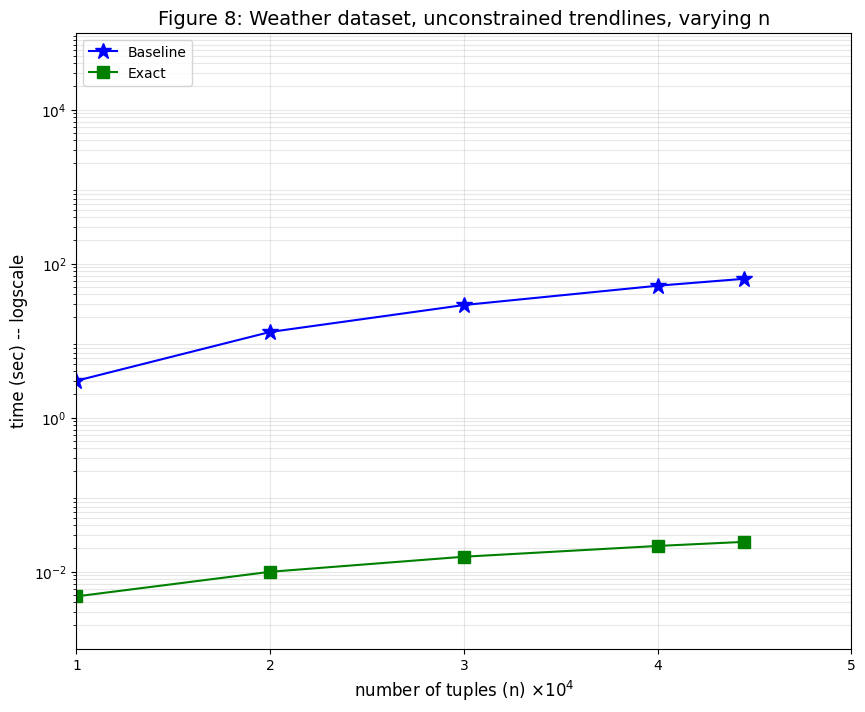

In [18]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Loading the dataset for the experiment
file_path = '/content/drive/MyDrive/DM-Project/temperature.csv'
df_weather = pd.read_csv(file_path)
# Extracting New York data and removing missing values
city_data = df_weather['New York'].dropna().values

# 2. Experimental Setup (Based on Paper Section 7.3.1)
# Splitting the data into two equal, non-overlapping pools
half = len(city_data) // 2
Rb_pool = city_data[:half]
Re_pool = city_data[half:]

# Defining input sizes (n) to measure performance growth
n_values = [10000, 20000, 30000, 40000, len(city_data)]
baseline_times = []
exact_times = []

# Measuring runtime for each input size
for n in n_values:
    # Ensuring each region has exactly n/2 points
    size_per_region = n // 2
    Rb = Rb_pool[:size_per_region]
    Re = Re_pool[:size_per_region]

    # Time measurement for Baseline Algorithm
    start = time.time()
    algorithm1_baseline(Rb, Re, bot='increase')
    baseline_times.append(time.time() - start)

    # Time measurement for Exact Algorithm
    start = time.time()
    algorithm2_exact(Rb, Re, bot='increase')
    exact_times.append(time.time() - start)

# 3. Graph Generation (Matching Figure 8 styling)
plt.figure(figsize=(10, 8))

# Plotting with specific markers and colors from the paper
plt.plot(n_values, baseline_times, label='Baseline', marker='*',
         markersize=12, color='blue', linestyle='-', linewidth=1.5)
plt.plot(n_values, exact_times, label='Exact', marker='s',
         markersize=8, color='green', linestyle='-', linewidth=1.5)

# Axis Formatting (Logarithmic Scale for clear comparison)
plt.yscale('log')
plt.yticks([1e-2, 1e0, 1e2, 1e4], [r'$10^{-2}$', r'$10^0$', r'$10^2$', r'$10^4$'])
plt.ylim(1e-3, 1e5)

# X-axis formatting (units of 10^4)
plt.xticks([10000, 20000, 30000, 40000, 50000], ['1', '2', '3', '4', '5'])
plt.xlim(10000, 50000)

plt.xlabel(r'number of tuples (n) $\times 10^4$', fontsize=12)
plt.ylabel('time (sec) -- logscale', fontsize=12)
plt.title('Figure 8: Weather dataset, unconstrained trendlines, varying n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

# **Support Measurement for Cherry-picked Statements (Reproduction of Figure 5)**

This experiment reproduces the results presented in Figure 5 of the paper, focusing on the real-world application of the support metric.

We analyze the statement: **"Summer was colder than winter in 2012."**   
While this claim is intuitively false for the Northern Hemisphere, a cherry-picker can find specific pairs of dates to support it.

We compute the support score ($\omega$) for various cities using the Exact Algorithm. The experiment demonstrates that while the support is extremely low across all cities (indicating a "statistical lie"), there are interesting variations based on local climate.

For example, cities with high temperature volatility (like Beersheba) show higher support than cities with more stable climates (like Vancouver). We also calculate the Overall Support as an average to show the global trend of this misleading claim.

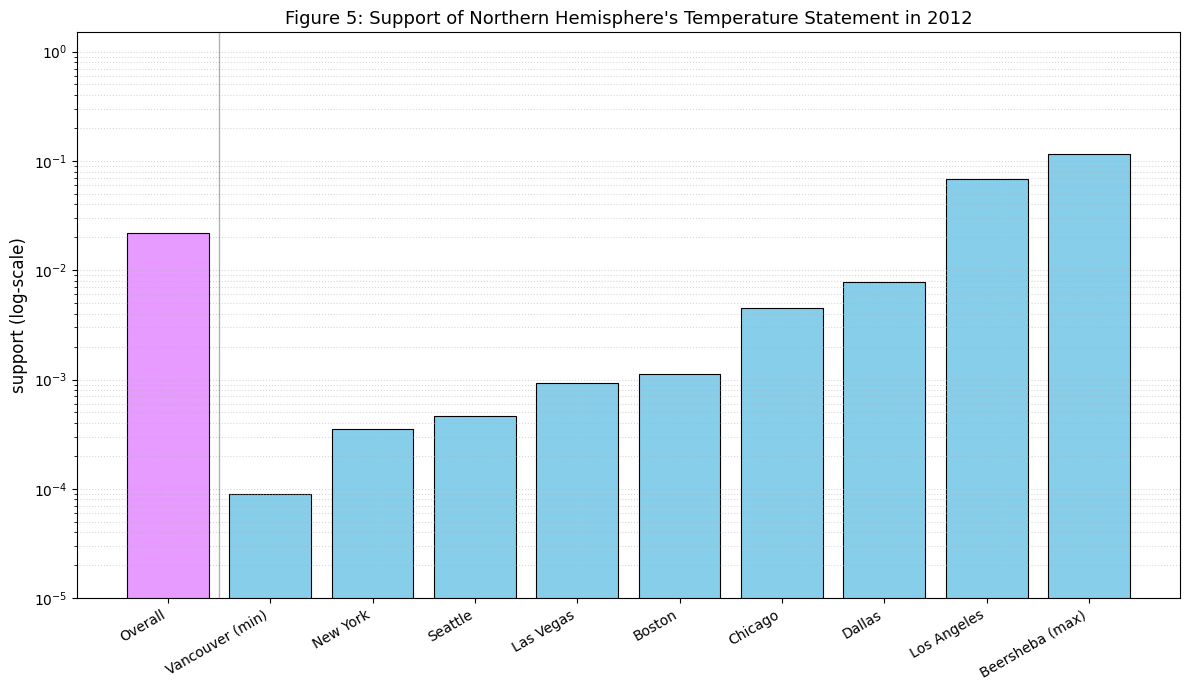

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Defining the seasonal time periods (Northern Hemisphere 2012-2013)
winter_mask = (df['datetime'] >= '2012-12-01') & (df['datetime'] <= '2013-03-01')
summer_mask = (df['datetime'] >= '2013-06-01') & (df['datetime'] <= '2013-09-01')

# 2. List of target cities and computing support for each
target_cities = ['Vancouver', 'New York', 'Seattle', 'Las Vegas', 'Boston', 'Chicago', 'Dallas', 'Los Angeles', 'Beersheba']
city_results = []

for city in target_cities:
    # Extracting temperature values for both regions and removing NaNs
    Rb = df.loc[winter_mask, city].dropna().values
    Re = df.loc[summer_mask, city].dropna().values

    # Claim: Summer colder than winter (Decrease semantics: x_e < x_b)
    omega = algorithm2_exact(Rb, Re, bot='decrease')
    city_results.append(omega)

# 3. Computing Overall Support (average across all analyzed cities)
overall_support = np.mean(city_results)

# 4. Preparing data for visualization following Figure 5 order
final_labels = ['Overall'] + [
    'Vancouver (min)', 'New York', 'Seattle', 'Las Vegas',
    'Boston', 'Chicago', 'Dallas', 'Los Angeles', 'Beersheba (max)'
]
final_values = [overall_support] + city_results

# 5. Visualizing the results with a bar chart
plt.figure(figsize=(12, 7))
colors = ['#e79aff'] + ['skyblue'] * (len(final_labels) - 1)
bars = plt.bar(final_labels, final_values, color=colors, edgecolor='black', linewidth=0.8)

# Formatting the Y-axis to a logarithmic scale (consistent with the paper)
plt.yscale('log')
plt.ylim(10**-5, 1.5)
plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
           [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^0$'])

# Design and Labels
plt.ylabel('support (log-scale)', fontsize=12)
plt.title('Figure 5: Support of Northern Hemisphere\'s Temperature Statement in 2012', fontsize=13)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', which="both", ls=":", alpha=0.5)

# Adding a visual separator for the 'Overall' category
plt.axvline(x=0.5, color='black', linestyle='-', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

CH

# **Detecting "Statistical Lies" in Bitcoin Market**

In this section, we extend the research beyond weather data to the highly volatile domain of cryptocurrency.

We apply the support metric to identify cherry-picked trendlines during two famous Bitcoin market cycles: the 2018 Crash and the 2017 Bull Run.

The goal is to demonstrate "Visual Lies":

**The 2018 "Fake Bull Market":** Finding a short-term upward trend in a year defined by a massive price collapse.

**The 2017 "Fake Bear Market":** Identifying a temporary price drop during a year of unprecedented historical growth.

By calculating the Global Support Score for these specific claims, we prove that while these trendlines are technically "accurate" (the points exist), they lack statistical support relative to the overall market behavior of that year, effectively making them cherry-picked.

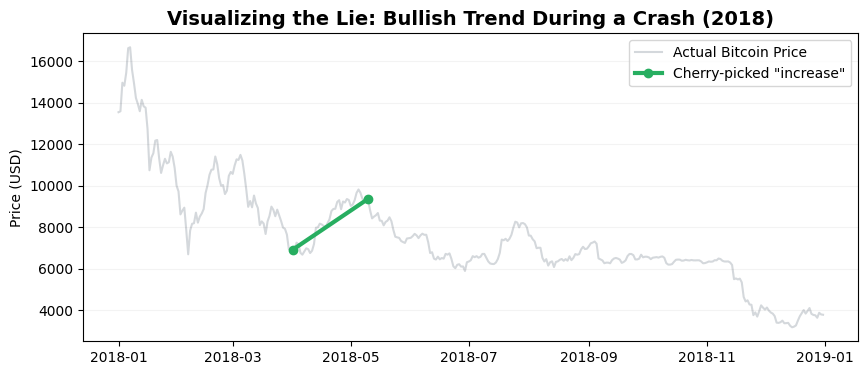

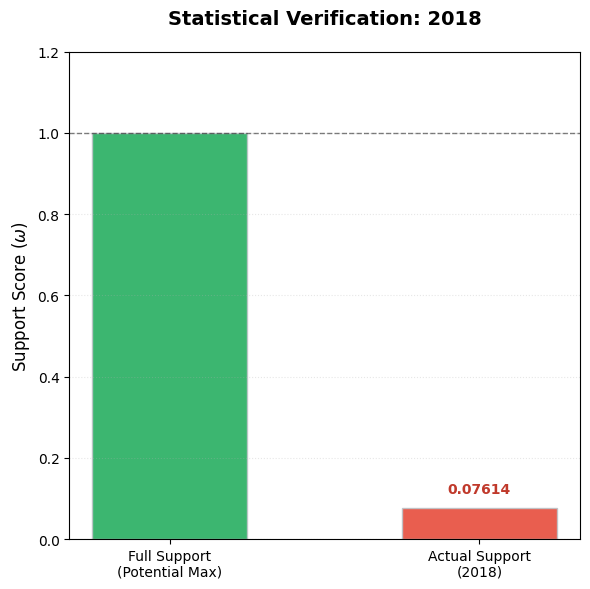

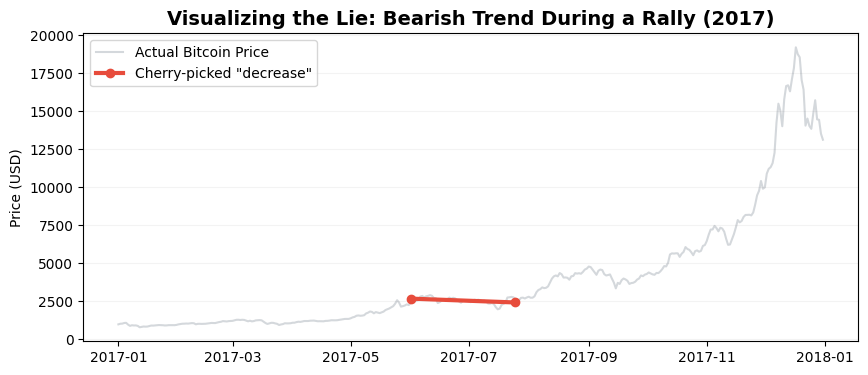

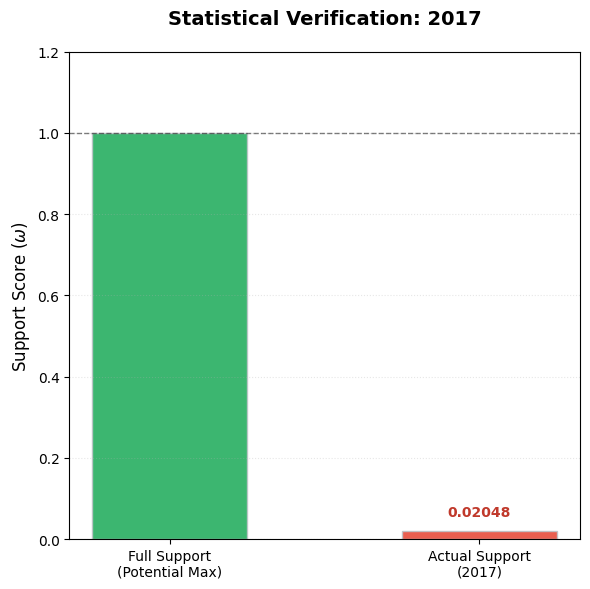

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import bisect

# --- 1. Optimized Support Calculation (Exact Algorithm) ---
def algorithm2_exact(Rb, Re, bot='increase'):
    """
    Computes the exact support score (omega) between two data ranges.
    Used here to verify Bitcoin trendlines.
    """
    if len(Rb) == 0 or len(Re) == 0:
        return 0

    Rb_sorted = sorted(Rb)
    n_b = len(Rb_sorted)
    count = 0

    for y_te in Re:
        if bot == 'increase':
            count += bisect.bisect_left(Rb_sorted, y_te)
        else: # decrease semantics
            idx = bisect.bisect_right(Rb_sorted, y_te)
            count += (n_b - idx)

    return count / (len(Rb) * len(Re))

# --- 2. Visualization Function: The Visual Lie ---
def plot_visual_lie(df, title, claim_type, year):
    """
    Plots a misleading trendline over the annual price data to visualize cherry-picking.
    """
    start_date, end_date = f'{year}-01-01', f'{year}-12-31'
    # Filtering data for the specific year
    df_p = df[(df['Timestamp'] >= pd.to_datetime(start_date)) & (df['Timestamp'] <= pd.to_datetime(end_date))].copy()

    # Defining the specific cherry-picked date ranges for Rb and Re
    if year == 2018:
        # A small rise in April/May during the 2018 crash
        rb_r, re_r = ('2018-04-01', '2018-04-10'), ('2018-05-01', '2018-05-10')
        line_color = '#27ae60' # Green for "Fake" Increase
    else:
        # A small drop in June/July during the 2017 bull run
        rb_r, re_r = ('2017-06-01', '2017-06-15'), ('2017-07-10', '2017-07-25')
        line_color = '#e74c3c' # Red for "Fake" Decrease

    # Extracting price values for the beginning and end regions
    Rb = df_p[(df_p['Timestamp'] >= pd.to_datetime(rb_r[0])) & (df_p['Timestamp'] <= pd.to_datetime(rb_r[1]))]['Close'].values
    Re = df_p[(df_p['Timestamp'] >= pd.to_datetime(re_r[0])) & (df_p['Timestamp'] <= pd.to_datetime(re_r[1]))]['Close'].values

    # Plotting the background price data (faded) and the cherry-picked line
    plt.figure(figsize=(10, 4))
    plt.plot(df_p['Timestamp'], df_p['Close'], color='#2c3e50', alpha=0.2, label='Actual Bitcoin Price')
    plt.plot([pd.to_datetime(rb_r[0]), pd.to_datetime(re_r[1])], [np.mean(Rb), np.mean(Re)],
             color=line_color, linestyle='-', linewidth=3, marker='o', label=f'Cherry-picked "{claim_type}"')

    plt.title(f"Visualizing the Lie: {title} ({year})", fontsize=14, fontweight='bold')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(axis='y', alpha=0.15)
    plt.show()

# --- 3. Statistical Verification: Support Bar Chart ---
def plot_global_support_bar(df, title, claim_type, year):
    """
    Visualizes the statistical support score on a linear scale to highlight the deception.
    """
    start_date, end_date = f'{year}-01-01', f'{year}-12-31'
    df_p = df[(df['Timestamp'] >= pd.to_datetime(start_date)) & (df['Timestamp'] <= pd.to_datetime(end_date))].copy()

    # Calculating global support for the entire year
    mid_point = len(df_p) // 2
    Rb_global = df_p.iloc[:mid_point]['Close'].values
    Re_global = df_p.iloc[mid_point:]['Close'].values
    omega_val = algorithm2_exact(Rb_global, Re_global, bot=claim_type)

    plt.figure(figsize=(6, 6))

    # Comparing our support score to a theoretical "Full Support" (1.0)
    labels = ['Full Support\n(Potential Max)', f'Actual Support\n({year})']
    values = [1.0, omega_val]
    colors = ['#27ae60', '#e74c3c'] # Green for reference, Red for our low score

    plt.bar(labels, values, color=colors, edgecolor='#bdc3c7', width=0.5, alpha=0.9)

    plt.yscale('linear')
    plt.ylim(0, 1.2)
    plt.ylabel(r'Support Score ($\omega$)', fontsize=12)
    plt.title(f"Statistical Verification: {year}", fontsize=14, fontweight='bold', pad=20)
    plt.grid(axis='y', ls=":", alpha=0.3)

    # Reference line at 1.0
    plt.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5)

    # Displaying the precise support value
    status_text = f'{omega_val:.5f}' if omega_val > 0 else "ZERO SUPPORT"
    plt.text(1, omega_val + 0.03, status_text, ha='center', va='bottom', fontweight='bold', color='#c0392b')

    plt.tight_layout()
    plt.show()

# --- 4. Running the Analysis ---
if 'df_btc' in locals():
    # Case 1: 2018 (The Crash) - Identifying a fake "Increase"
    plot_visual_lie(df_btc, "Bullish Trend During a Crash", "increase", 2018)
    plot_global_support_bar(df_btc, "2018 Global Support Analysis", "increase", 2018)

    # Case 2: 2017 (The Bull Run) - Identifying a fake "Decrease"
    plot_visual_lie(df_btc, "Bearish Trend During a Rally", "decrease", 2017)
    plot_global_support_bar(df_btc, "2017 Global Support Analysis", "decrease", 2017)